In [1]:
import os
import pandas as pd
import numpy as np
from sktime.regression.interval_based import TimeSeriesForestRegressor
from sktime.forecasting.compose import make_reduction
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.base import ForecastingHorizon
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt


notebook_dir = os.path.dirname(os.path.abspath("__file__"))
csv_path = os.path.join(notebook_dir, '..', 'clean_data', 'main_df_clean.csv')

In [2]:
merged_df = pd.read_csv(csv_path)
merged_df

,Date,brl Exchange Rate,vnd Exchange Rate,hnl Exchange Rate,idr Exchange Rate,Coffee,Milk,Sugar,Tea,cop Exchange Rate,...,Honduras_wind_speed_10m_max_hon,Honduras_wind_gusts_10m_max_hon,Honduras_et0_fao_evapotranspiration_hon,Indonesia_temperature_2m_mean_in,Indonesia_daylight_duration_in,Indonesia_sunshine_duration_in,Indonesia_precipitation_sum_in,Indonesia_wind_speed_10m_max_in,Indonesia_wind_gusts_10m_max_in,Indonesia_et0_fao_evapotranspiration_in
0,1990-01,0.000006,5479.329529,2.0000,1804.850000,0.758300,0.070170,0.142000,1.147273,440.08,...,10.069539,31.134193,3.320075,25.252577,12.287324,8.420801,6.867742,12.574532,32.876128,3.412106
1,1990-02,0.000010,5479.329529,2.0000,1809.870000,0.840100,0.074822,0.146500,0.958396,451.72,...,10.732204,30.805714,3.872699,25.438890,12.215222,9.179367,8.982143,9.290742,24.480000,3.518966
2,1990-03,0.000016,5479.329529,4.0000,1820.350000,0.939600,0.074173,0.153100,0.873620,463.40,...,11.773626,34.803870,4.214509,25.706005,12.125023,9.753625,9.561290,8.809619,24.607741,3.814265
3,1990-04,0.000021,5479.329529,4.0000,1826.050000,0.937300,0.077387,0.152400,0.883644,474.62,...,11.712375,34.319999,4.871768,26.231305,12.035547,9.697712,6.286667,7.469806,20.340000,3.766648
4,1990-05,0.000023,5563.430866,4.2000,1831.400000,0.920200,0.088704,0.146200,0.848309,485.99,...,10.483667,32.736774,4.842873,26.307215,11.964987,9.630981,5.732258,7.962735,22.389677,3.583512
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
414,2024-07,5.541448,24251.560000,24.8582,16261.652826,2.570987,0.242129,0.193517,1.363518,4036.80,...,15.246755,35.698063,4.118606,26.897843,11.948145,10.162547,3.645161,12.121012,28.834838,4.220664
415,2024-08,5.552014,24245.850000,24.8826,15793.181818,2.614377,0.244700,0.184195,1.467152,4062.98,...,15.815804,37.312257,4.518683,28.485544,12.008544,10.225594,1.296774,14.199244,34.281289,4.954863
416,2024-09,5.540967,24163.540000,24.8381,15341.250000,2.787605,0.251466,0.206248,1.572990,4191.86,...,11.425362,28.991999,4.216293,27.723999,12.092080,9.381017,6.356667,12.624396,28.259999,4.434608
417,2024-10,5.623509,24192.520000,24.9661,15541.347826,2.767774,0.238592,0.223552,1.490232,4257.76,...,16.502540,38.984515,3.515946,27.594483,12.184385,10.091865,4.106452,11.833299,26.512257,4.686166


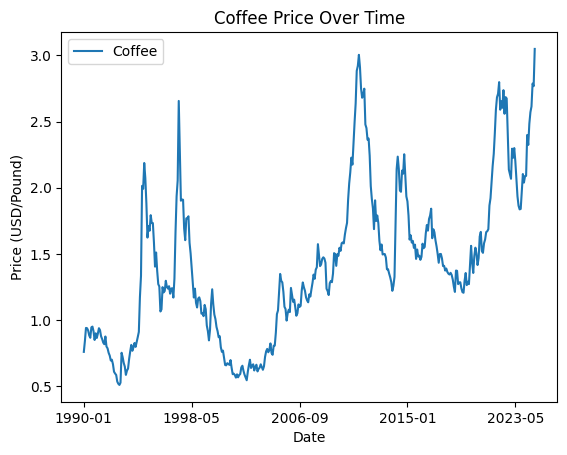

In [3]:
merged_df.plot(x='Date', y='Coffee', title='Coffee Price Over Time')  
plt.xlabel('Date')
plt.ylabel('Price (USD/Pound)')
plt.show()

In [33]:
target_col = 'Coffee'
X_col = merged_df.drop(columns=[target_col])
y_col = merged_df[target_col]

window_size = 30

X = []
y = []
for i in range(len(X_col) - window_size):
    X.append(X_col.iloc[i:i+window_size].values)
    y.append(y_col.iloc[i+window_size])

X = np.array(X).reshape(-1, 1, window_size) 
y = np.array(y)

In [34]:
X_train, X_test, y_train, y_test = temporal_train_test_split(y, X=X, test_size=0.2)

print(f"Train size: {len(X_train)}, Test size: {len(X_test)}")

Train size: 311, Test size: 78


In [40]:
regressor = TimeSeriesForestRegressor(
    n_estimators=100,
    min_interval=3,
    random_state=42
)

if y_train.ndim == 2:
    y_train = pd.DataFrame(y_train)

regressor.fit(X_train, y_train)

/home/juan1guerra/.local/lib/python3.11/site-packages/sktime/utils/slope_and_trend.py:83: RuntimeWarning: invalid value encountered in divide
  return (np.mean(y * x, axis=axis) - x_mean * np.mean(y, axis=axis)) / (
/home/juan1guerra/.local/lib/python3.11/site-packages/sktime/utils/slope_and_trend.py:83: RuntimeWarning: invalid value encountered in divide
  return (np.mean(y * x, axis=axis) - x_mean * np.mean(y, axis=axis)) / (
/home/juan1guerra/.local/lib/python3.11/site-packages/sktime/utils/slope_and_trend.py:83: RuntimeWarning: invalid value encountered in divide
  return (np.mean(y * x, axis=axis) - x_mean * np.mean(y, axis=axis)) / (
/home/juan1guerra/.local/lib/python3.11/site-packages/sktime/utils/slope_and_trend.py:83: RuntimeWarning: invalid value encountered in divide
  return (np.mean(y * x, axis=axis) - x_mean * np.mean(y, axis=axis)) / (
/home/juan1guerra/.local/lib/python3.11/site-packages/sktime/utils/slope_and_trend.py:83: RuntimeWarning: invalid value encountered in d

TimeSeriesForestRegressor(n_estimators=100, random_state=42)

In [42]:
y_pred = regressor.predict(X_test)

/home/juan1guerra/.local/lib/python3.11/site-packages/sktime/utils/slope_and_trend.py:83: RuntimeWarning: invalid value encountered in divide
  return (np.mean(y * x, axis=axis) - x_mean * np.mean(y, axis=axis)) / (
/home/juan1guerra/.local/lib/python3.11/site-packages/sktime/utils/slope_and_trend.py:83: RuntimeWarning: invalid value encountered in divide
  return (np.mean(y * x, axis=axis) - x_mean * np.mean(y, axis=axis)) / (
/home/juan1guerra/.local/lib/python3.11/site-packages/sktime/utils/slope_and_trend.py:83: RuntimeWarning: invalid value encountered in divide
  return (np.mean(y * x, axis=axis) - x_mean * np.mean(y, axis=axis)) / (
/home/juan1guerra/.local/lib/python3.11/site-packages/sktime/utils/slope_and_trend.py:83: RuntimeWarning: invalid value encountered in divide
  return (np.mean(y * x, axis=axis) - x_mean * np.mean(y, axis=axis)) / (
/home/juan1guerra/.local/lib/python3.11/site-packages/sktime/utils/slope_and_trend.py:83: RuntimeWarning: invalid value encountered in d

In [46]:
def print_metrics(y_true, y_pred):
    print(f"MAE: {mean_absolute_error(y_true, y_pred):.2f}")
    print(f"MSE: {mean_squared_error(y_true, y_pred):.2f}")

# Reshape y_test and y_pred if they are 3-dimensional
if y_test.ndim == 3 and y_test.shape[1] == 1:
    y_test = y_test.reshape(y_test.shape[0], y_test.shape[2])

if y_pred.ndim == 3 and y_pred.shape[1] == 1:
    y_pred = y_pred.reshape(y_pred.shape[0], y_pred.shape[2])

# Convert y_test and y_pred to 1-dimensional if they have only one feature
if y_test.ndim == 2 and y_test.shape[1] == 1:
    y_test = y_test.flatten()

if y_pred.ndim == 2 and y_pred.shape[1] == 1:
    y_pred = y_pred.flatten()

# Print metrics
print_metrics(y_test, y_pred)

MAE: 632.81
MSE: 5196313.98


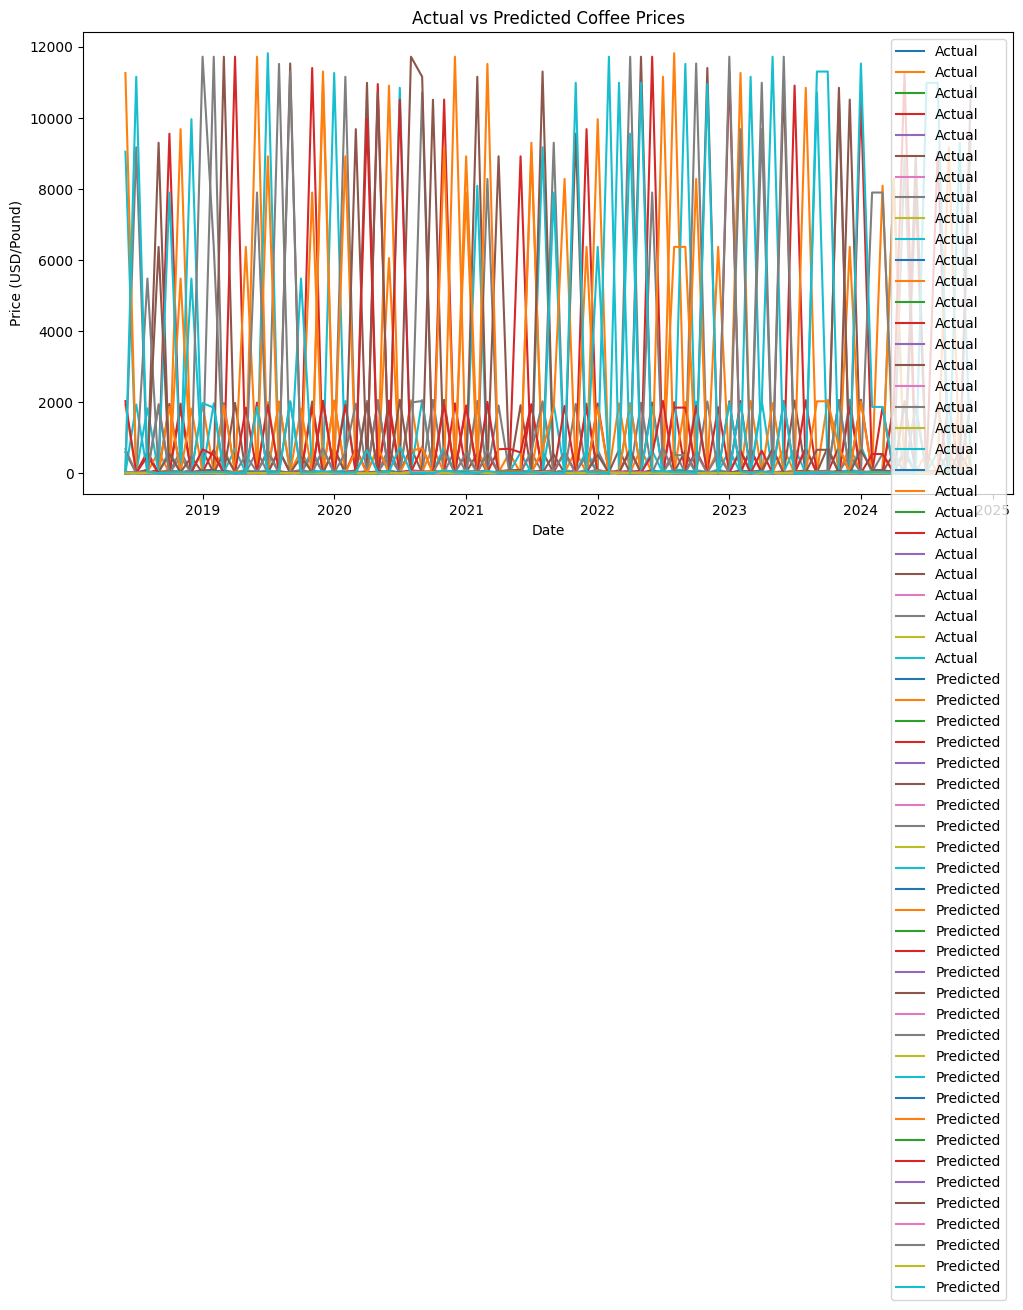

In [48]:
plt.figure(figsize=(12, 6))
plt.plot(merged_df.index[-len(y_test):], y_test, label='Actual')
plt.plot(merged_df.index[-len(y_test):], y_pred, label='Predicted')
plt.title('Actual vs Predicted Coffee Prices')
plt.xlabel('Date')
plt.ylabel('Price (USD/Pound)')
plt.legend()
plt.show()